In [1]:
import sys
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from imports import *
from lat_weight_mean import lat_weight_mean
from load_xarray import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cyclone_obs import *
from cyclone_metrics import *
from my_binned import *

ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


In [2]:
# PNAS font sizes
title_fontsize = 8
label_fontsize = 7
tick_fontsize = 6
fig_dir = '/glade/derecho/scratch/geethma/figures_GFB/'

In [3]:
# --- TOA means
from TOAf import *
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)
common_members = filtered_TOA_15.runs
common_members = common_members[common_members != 175]

In [4]:
# --- maps of the PPE variables I need
var_list = ['dTSmap_gol', 'dLWPmap_gol', 'pe_maps_ol', 'dPE_maps_gol']  # , 'dSWCREmap', 'dLWCREmap', 'wvp_maps_ol', 'w500_maps_ol', 
var_dict = {var: load_xarray(var) for var in var_list}

### Select only common runs for all datasets
var_keys = list(var_dict.keys())
for name in var_keys:
    print(name)
    common_members = np.intersect1d(common_members, var_dict[name]["runs"].values)

var_dict = {name: ds.sel(runs=common_members) for name, ds in var_dict.items()}

dGMT = lat_weight_mean(var_dict['dTSmap_gol'])[0]  # ∆GMT [K]
pe_maps_ol = var_dict['pe_maps_ol']*86400  # PD P-E [kgm-2day-1]
dLWP_g = var_dict['dLWPmap_gol']/dGMT  # ∆LWP/∆GMT [kgm-2K-1] 
dPE = var_dict['dPE_maps_gol']*86400 /dGMT  # ∆P-E/∆GMT [kgm-2day-1K-1]

dTSmap_gol
dLWPmap_gol
pe_maps_ol
dPE_maps_gol


In [5]:
# all pressure all cloud feedbacks
ds_kernel = {}
for mem_run in common_members:
    pk = 'all_pressure'
    tk = 'all'

    mem = str(mem_run).zfill(3)
    path = (
        f"/glade/derecho/scratch/travisa/CAM6_kernels/"
        f"member_number_{mem}/"
        f"CAM6_PPE_CRK_decomp_{pk}_{tk}_cloud.nc"
    )

    if not os.path.exists(path):
        print(f"Skipping member {mem}: file not found")
        continue

    ds_kernel[mem + pk + tk] = xr.open_dataset(path)

# now for kernel feedback take the global, subtropical, and midltitude means
def trav_fbvar(fbvar, region_dic, ds_kernel=ds_kernel, dGMT=dGMT, common_members=common_members):
    '''return each cloud feedback variable separated into regions.
       fbvar is the feedback component name in strings.'''

    regions = list(region_dic.keys())
    
    SWkernel_regmean = {}
    for reg in (regions):
        SWkernel_list = []
        for mem_run in (common_members):
            mem = str(mem_run).zfill(3)
            SWkernel = ds_kernel[mem+'all_pressure'+'all'][fbvar].mean('time')
            SWkernel_list.append(SWkernel)
    
        SWkernel_all = xr.concat(SWkernel_list,'runs').assign_coords({'runs':common_members})
        SWkernel_regmean[reg] = SWkernel_all.load()/dGMT
    return SWkernel_regmean

# cloud feedback components
region_dic = {
    'global' : [0, 90]
}
LWcld_tot_fb_global = trav_fbvar('LWcld_tot', region_dic)
SWcld_tot_fb_global = trav_fbvar('SWcld_tot', region_dic)
LWcld_tot_fb_global = LWcld_tot_fb_global['global'].sel(runs=common_members)
SWcld_tot_fb_global = SWcld_tot_fb_global['global'].sel(runs=common_members)
totdCRE_g = LWcld_tot_fb_global + SWcld_tot_fb_global


In [6]:
print(np.array_equal(
    totdCRE_g.runs,
    dPE.runs
))


True


In [7]:
# --- cyclone EC observations
from cyclone_obs import *
obs_dict = cyclone_obs()

cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
prc = obs_dict['MWprecipitation']/3600.  #[mm/s]
num_bins = 10
ind = np.isnan(prc*cloudlwp)==False

### take weighted bins
lwp_bin = stats.binned_statistic(prc[ind], cloudlwp[ind], statistic='mean', bins=num_bins)[0]
prc_bin = stats.binned_statistic(prc[ind], prc[ind], statistic='mean', bins=num_bins)[0]
count   = stats.binned_statistic(prc[ind], prc[ind], statistic='count', bins=num_bins)[0]
obs_grad = np.nansum(np.gradient(lwp_bin)/np.gradient(prc_bin)*count)/np.nansum(count)

obs_grad_LWP_PRC = 1/obs_grad

ecpe_uncertainty = np.sqrt(0.10**2 + 0.35**2 + 0.27**2)  # updated to include the sampling uncertainty
lower_bound_PRC = obs_grad_LWP_PRC - ecpe_uncertainty * obs_grad_LWP_PRC
upper_bound_PRC = obs_grad_LWP_PRC + ecpe_uncertainty * obs_grad_LWP_PRC

obs_pe_metric = obs_grad_LWP_PRC  # observational EC precipitation efficiency
lower_pe_metric, upper_pe_metric = lower_bound_PRC, upper_bound_PRC  # upper and lower bounds with uncertainty
print(f'obs_grad_LWP_PRC = {obs_grad_LWP_PRC} +/- {ecpe_uncertainty * obs_grad_LWP_PRC}')

obs_grad_LWP_PRC = 0.0014278375841849642 +/- 0.0006471113677436142


In [8]:
# --- ecpe metric
_, PPE_grad_LWP_PRC = cyclone_metrics()
PPE_grad_LWP_PRC = 1./(PPE_grad_LWP_PRC.sel(runs=common_members)*86400.)  # [s-1]
# PPE_grad_LWP_WCB = 1/(PPE_grad_LWP_WCB.sel(runs=common_members))

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import spearmanr, linregress


# def bootstrap_corr_and_regression(
#     X,
#     Y,
#     n_boot=10000,
#     ci=(16, 84),
#     outer_ci=(5, 95),
#     rng_seed=42,
#     plot=True,
#     annotate=True,
#     color_line='0.4',
#     color_fill='steelblue'
# ):
#     """
#     Bootstrap Spearman correlation and linear regression.

#     Parameters
#     ----------
#     X, Y : array-like
#         1D data arrays
#     n_boot : int
#         Number of bootstrap samples
#     ci : tuple
#         Inner confidence interval percentiles
#     outer_ci : tuple
#         Outer confidence interval percentiles
#     rng_seed : int
#         Random seed
#     plot : bool
#         Whether to plot regression + envelope
#     annotate : bool
#         Whether to annotate Spearman r on axes

#     Returns
#     -------
#     results : dict
#         Dictionary with correlation and regression statistics
#     """

#     X = np.asarray(X)
#     Y = np.asarray(Y)

#     mask = np.isfinite(X) & np.isfinite(Y)
#     X = X[mask]
#     Y = Y[mask]

#     N = len(X)
#     if N < 3:
#         raise ValueError("Not enough valid points for bootstrap")

#     rng = np.random.default_rng(rng_seed)

#     # -----------------------------
#     # Bootstrap correlation
#     # -----------------------------
#     r_boot = np.empty(n_boot)
#     slope_boot = np.empty(n_boot)
#     intercept_boot = np.empty(n_boot)

#     for i in range(n_boot):
#         idx = rng.integers(0, N, N)

#         r_boot[i], _ = spearmanr(X[idx], Y[idx])

#         res = linregress(X[idx], Y[idx])
#         slope_boot[i] = res.slope
#         intercept_boot[i] = res.intercept

#     # Correlation stats
#     r_med = np.median(r_boot)
#     r_lo, r_hi = np.percentile(r_boot, ci)

#     # Regression envelope
#     x_fit = np.linspace(X.min(), X.max(), 200)
#     y_boot = slope_boot[:, None] * x_fit + intercept_boot[:, None]

#     y_med = np.median(y_boot, axis=0)
#     y_lo, y_hi = np.percentile(y_boot, ci, axis=0)
#     y_lo2, y_hi2 = np.percentile(y_boot, outer_ci, axis=0)

#     # -----------------------------
#     # Plot
#     # -----------------------------
#     if plot:
#         plt.plot(x_fit, y_med, color=color_line, lw=2)

#         plt.fill_between(
#             x_fit, y_lo, y_hi,
#             color=color_fill, alpha=0.25
#         )

#         plt.plot(x_fit, y_lo2, color='0.6', ls='--')
#         plt.plot(x_fit, y_hi2, color='0.6', ls='--')

#     if annotate:
#         plt.text(
#             0.05, 0.95,
#             rf"Spearman $r$ = {r_med:.2f} "
#             rf"[{r_lo:.2f}, {r_hi:.2f}]",
#             transform=plt.gca().transAxes,
#             va='top'
#         )

#     return {
#         "r_median": r_med,
#         "r_ci": (r_lo, r_hi),
#         "r_boot": r_boot,
#         "slope_boot": slope_boot,
#         "intercept_boot": intercept_boot,
#         "x_fit": x_fit,
#         "y_median": y_med,
#         "y_ci": (y_lo, y_hi),
#         "y_outer_ci": (y_lo2, y_hi2),
#     }


In [10]:
def sel_regime(xarray, lat_min, lat_max):
    north = xarray.sel(lat=slice(lat_min, lat_max))
    south = xarray.sel(lat=slice(-lat_max, -lat_min))
    xarray_sel = xr.concat([south, north], dim='lat')
    print(xarray_sel.shape)

    return xarray_sel

In [11]:
# --- get da/dlwp
# load da/dlwp from Ci's saved data
dadlwp_file  = glob.glob('/glade/u/home/cisong/test_codes/codes_figures/slopes/0dot12_15dgrN_dadlwp_ppe_maskedlwp/reg_10_90_mem_*.npz')
# ALBEDO SUSCEPTIBILITY
# PPE da/dlwp
dadlwp = []
dadlwp_runs = []
for i in common_members:
    # print(i)
    #dadlwp_file  = np.load('/glade/u/home/cisong/test_codes/radiation/slopes/reg_10_90_mem_'+str(i).zfill(3)+'.npz')
    dadlwp_file  = np.load('/glade/u/home/cisong/test_codes/codes_figures/slopes/0dot12_15dgrN_dadlwp_ppe_maskedlwp/reg_10_90_mem_'+str(i).zfill(3)+'.npz')

    dadlwp.append(dadlwp_file['m_wght_mn_grd'])
    dadlwp_runs.append(dadlwp_file['ensn'])
dadlwp = xr.DataArray(dadlwp, dims=['runs'], coords={'runs':dadlwp_runs})

# Get the time mean clwp observations from MAC-LWP dataset
files = sorted(glob.glob('/glade/derecho/scratch/geethma/new_MACLWP/*.nc4'))

da_all = xr.concat(
    [xr.open_dataset(f)["meanfit"] for f in files],
    dim="time"
)

ds_mean = da_all.mean(dim="time", skipna=True)*0.001  # unit [kgm-2]

def dadlwp_func(PD_LWP_mean):
    # Use [50, 90] da/dlwp and PD LWP correlation to get the best fit for dadlwp for the PD_LWP_mean
    
    _assert_same_coords(PD_LWP_mean, dadlwp)
    min_lat,max_lat = [50, 90]
    dLWP_TSmap_midlatitude = sel_regime(PDLWP.sel(runs=common_members),min_lat,max_lat)
    dLWP_TSmap_midlatitude_mean = lat_weight_mean(dLWP_TSmap_midlatitude)[0]
    
    X = dLWP_TSmap_midlatitude_mean.data
    Y = dadlwp.data
    mask = np.isfinite(X) & np.isfinite(Y) & (X > 0)
    X = X[mask]
    Y = Y[mask]
    plot_X = X; xlabel = f'PD LWP [kgm$^{-2}$]'
    plot_Y = dadlwp; ylabel = f'PD ∂α/∂LWP'
    plt.figure()
    plt.scatter(plot_X, plot_Y, alpha=0.7)
    
    # --- best fit
    idx = np.argsort(plot_X)
    plot_X_sorted = plot_X[idx]
    plot_Y_sorted = plot_Y[idx]
    from scipy.optimize import curve_fit
    #Define a Non-Linear model function
    def non_linear_model(x, a, b, c):
        return a * x**(-b) + c
    #Fitting of Non-Linear model to the generated data 
    Optimal_param, covariance = curve_fit(non_linear_model, plot_X_sorted, plot_Y_sorted)
    #Making predictions using the Fitting model 
    y_pred=non_linear_model(plot_X_sorted, *Optimal_param)
    # R²
    ss_res = np.sum((plot_Y_sorted - y_pred)**2)
    ss_tot = np.sum((plot_Y_sorted - np.mean(plot_Y_sorted))**2)
    r_squared = 1 - ss_res/ss_tot
    print("R²:", r_squared)
    # plot the best fit
    plt.plot(plot_X_sorted, y_pred, 'r-')

    # midlatitude observation line
    dadlwp_obs = np.load('/glade/derecho/scratch/cisong/backup_FOR_wyom0124/variables_filtered/15dgrNorth_da_dlwp_obs_0dot12_maskedLWP.npy')
    dadlwp_err = np.sqrt(0.1**2+0.03**2)  # Ci sent this. Check teams 5/8/24
    lower_bound_dadlwp = dadlwp_obs - dadlwp_err * dadlwp_obs
    upper_bound_dadlwp = dadlwp_obs + dadlwp_err * dadlwp_obs
    plt.axhline(dadlwp_obs, color='grey', linestyle='--', label='Observations')
    plt.axhspan(lower_bound_dadlwp, upper_bound_dadlwp, facecolor='grey', alpha=0.3)

    ds_mean_midlatitude = sel_regime(ds_mean,min_lat,max_lat)
    PDLWP_MAC_midlatitude = lat_weight_mean(ds_mean_midlatitude)[0]
    # dadlwp_MAC_midlatitude = non_linear_model(PDLWP_MAC_midlatitude, *Optimal_param)
    # print('dadlwp_MAC_midlatitude ',dadlwp_MAC_midlatitude)
    plt.axvline(PDLWP_MAC_midlatitude, color='yellow', label='PD LWP from MACLWP')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    dadlwp_MAC = non_linear_model(PDLWP_MAC_midlatitude, *Optimal_param)
    dadlwp_PPE = non_linear_model(PD_LWP_mean, *Optimal_param)
    return dadlwp_MAC, dadlwp_PPE


In [12]:
def _assert_same_coords(*das):
    """
    Assert that multiple xarray DataArrays share identical coordinates.
    """
    ref = das[0]
    coords = tuple(ref.coords)
    for da in das[1:]:
        for c in coords:
            if c not in ref.coords or c not in da.coords:
                raise ValueError(f"Missing coord '{c}' in one of the inputs")

            if not np.array_equal(ref[c].values, da[c].values):
                raise ValueError(
                    f"Coordinate '{c}' mismatch between arrays:\n"
                    f"ref[{c}] = {ref[c].values}\n"
                    f"da [{c}] = {da[c].values}"
                )


In [13]:
def to_lon180(da):
    lon = da.lon
    lon_new = ((lon + 180) % 360) - 180
    return (
        da.assign_coords(lon=lon_new)
          .sortby('lon')
    )


In [14]:
def pos_correlation(
    give_var, give_var_nm,
    color_by, color_by_nm,
    totcld_tau_amt, totcld_tau_amt_nm,
    frac_pos_thresh,
    lat_range=None
):
    # Ensure all inputs are xarrays
    for name, da in zip(
        ['give_var', 'color_by', 'totcld_tau_amt'],
        [give_var, color_by, totcld_tau_amt]
    ):
        if not isinstance(da, xr.DataArray):
            raise TypeError(f"{name} must be an xarray.DataArray")
    # make lons to be [-180, 180]
    give_var = to_lon180(give_var)
    color_by = to_lon180(color_by)
    totcld_tau_amt = to_lon180(totcld_tau_amt)
    # Enforce identical coordinates
    _assert_same_coords(give_var, color_by, totcld_tau_amt)
    # --- Build mask: positive & finite give_var
    frac_pos = np.mean(give_var.values > 0, axis=0)
    mask_pos = frac_pos >= frac_pos_thresh

    # --------------------------------------------------
    # Add latitude mask (optional)
    # --------------------------------------------------
    if lat_range is not None:
        lat_min, lat_max = lat_range
        mask_lat = (totcld_tau_amt.lat >= lat_min) & (totcld_tau_amt.lat <= lat_max)
        mask_lat = mask_lat.broadcast_like(totcld_tau_amt)
    else:
        mask_lat = xr.ones_like(totcld_tau_amt, dtype=bool)

    # Combine masks
    mask = mask_pos & mask_lat

    # --------------------------------------------------
    # Mask give_var
    # --------------------------------------------------    
    give_var_xr = give_var.where(mask)
    give_var_xr.name = give_var_nm
    plt.figure(); give_var_xr[0].plot(cmap='seismic')

    # --------------------------------------------------
    # Mask cloud feedback
    # --------------------------------------------------
    totcld_tau_amt_g_xr = totcld_tau_amt.where(mask)
    totcld_tau_amt_g_xr.name = totcld_tau_amt_nm
    plt.figure(); totcld_tau_amt_g_xr[0].plot(cmap='seismic')

    # --- Prepare & mask color_by
    color_by = np.asarray(color_by)
    if color_by.ndim == 1:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('runs',),
            coords={'runs': totcld_tau_amt.runs}
        ).broadcast_like(totcld_tau_amt)
    elif color_by.ndim == 2:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('lat', 'lon'),
            coords={
                'lat': totcld_tau_amt.lat,
                'lon': totcld_tau_amt.lon,
            }
        ).broadcast_like(totcld_tau_amt)
    elif color_by.ndim == 3:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('runs', 'lat', 'lon'),
            coords={
                'runs': totcld_tau_amt.runs,
                'lat': totcld_tau_amt.lat,
                'lon': totcld_tau_amt.lon,
            }
        )
    else:
        raise ValueError("color_by must be 1D, 2D, or 3D")

    # --- Mask color_by variable
    dLWP_g_xr = color_by_xr.where(mask)
    dLWP_g_xr.name = color_by_nm
    plt.figure(); dLWP_g_xr[0].plot(cmap='seismic')

    # --- Latitude-weighted means
    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_g_xr)[0]
    cf_mean = lat_weight_mean(totcld_tau_amt_g_xr)[0]

    # --- Output precipitation efficiency, cloud feedback, and colored_by variables
    _assert_same_coords(PPE_grad_LWP_PRC, cf_mean, dLWP_TSmap_sel_mean)

    X_scatter = PPE_grad_LWP_PRC
    Y_scatter = cf_mean
    C_scatter = dLWP_TSmap_sel_mean
    # --- Constrained runs
    mask_cons = (
        (PPE_grad_LWP_PRC >= lower_pe_metric) &
        (PPE_grad_LWP_PRC <= upper_pe_metric)
    )
    PPE_constrained = PPE_grad_LWP_PRC.where(mask_cons, drop=True)
    constrained_positive = cf_mean.where(
        cf_mean['runs'].isin(PPE_constrained['runs']),
        drop=True
    )

    return PPE_constrained, constrained_positive, cf_mean, X_scatter, Y_scatter, C_scatter, mask
    


In [15]:
def neg_correlation(
    give_var, give_var_nm,
    color_by, color_by_nm,
    totcld_tau_amt, totcld_tau_amt_nm,
    frac_pos_thresh,
    lat_range=None
):
    # Ensure all inputs are xarrays
    for name, da in zip(
        ['give_var', 'color_by', 'totcld_tau_amt'],
        [give_var, color_by, totcld_tau_amt]
    ):
        if not isinstance(da, xr.DataArray):
            raise TypeError(f"{name} must be an xarray.DataArray")
    # make lons to be [-180, 180]
    give_var = to_lon180(give_var)
    color_by = to_lon180(color_by)
    totcld_tau_amt = to_lon180(totcld_tau_amt)
    # Enforce identical coordinates
    _assert_same_coords(give_var, color_by, totcld_tau_amt)
    # --- Build mask: positive & finite give_var
    frac_pos = np.mean(give_var.values < 0, axis=0)
    mask_pos = frac_pos >= frac_pos_thresh

    # --------------------------------------------------
    # Add latitude mask (optional)
    # --------------------------------------------------
    if lat_range is not None:
        lat_min, lat_max = lat_range
        mask_lat = (totcld_tau_amt.lat >= lat_min) & (totcld_tau_amt.lat <= lat_max)
        mask_lat = mask_lat.broadcast_like(totcld_tau_amt)
    else:
        mask_lat = xr.ones_like(totcld_tau_amt, dtype=bool)

    # Combine masks
    mask = mask_pos & mask_lat

    # --------------------------------------------------
    # Mask give_var
    # --------------------------------------------------    
    give_var_xr = give_var.where(mask)
    give_var_xr.name = give_var_nm
    plt.figure(); give_var_xr[0].plot(cmap='seismic')

    # --------------------------------------------------
    # Mask cloud feedback
    # --------------------------------------------------
    totcld_tau_amt_g_xr = totcld_tau_amt.where(mask)
    totcld_tau_amt_g_xr.name = totcld_tau_amt_nm
    plt.figure(); totcld_tau_amt_g_xr[0].plot(cmap='seismic')

    # --- Prepare & mask color_by
    color_by = np.asarray(color_by)
    if color_by.ndim == 1:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('runs',),
            coords={'runs': totcld_tau_amt.runs}
        ).broadcast_like(totcld_tau_amt)
    elif color_by.ndim == 2:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('lat', 'lon'),
            coords={
                'lat': totcld_tau_amt.lat,
                'lon': totcld_tau_amt.lon,
            }
        ).broadcast_like(totcld_tau_amt)
    elif color_by.ndim == 3:
        color_by_xr = xr.DataArray(
            color_by,
            dims=('runs', 'lat', 'lon'),
            coords={
                'runs': totcld_tau_amt.runs,
                'lat': totcld_tau_amt.lat,
                'lon': totcld_tau_amt.lon,
            }
        )
    else:
        raise ValueError("color_by must be 1D, 2D, or 3D")

    # --- Mask color_by variable
    dLWP_g_xr = color_by_xr.where(mask)
    dLWP_g_xr.name = color_by_nm
    plt.figure(); dLWP_g_xr[0].plot(cmap='seismic')

    # --- Latitude-weighted means
    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_g_xr)[0]
    cf_mean = lat_weight_mean(totcld_tau_amt_g_xr)[0]

    # --- Output precipitation efficiency, cloud feedback, and colored_by variables
    _assert_same_coords(PPE_grad_LWP_PRC, cf_mean, dLWP_TSmap_sel_mean)

    X_scatter = PPE_grad_LWP_PRC
    Y_scatter = cf_mean
    C_scatter = dLWP_TSmap_sel_mean
    # --- Constrained runs
    mask_cons = (
        (PPE_grad_LWP_PRC >= lower_pe_metric) &
        (PPE_grad_LWP_PRC <= upper_pe_metric)
    )
    PPE_constrained = PPE_grad_LWP_PRC.where(mask_cons, drop=True)
    constrained_positive = cf_mean.where(
        cf_mean['runs'].isin(PPE_constrained['runs']),
        drop=True
    )

    return PPE_constrained, constrained_positive, cf_mean, X_scatter, Y_scatter, C_scatter, mask
    

# PD MC

(199, 86, 288)
R²: <xarray.DataArray ()>
array(0.94482853)
(80, 360)
efficiency_product = <xarray.DataArray 'meanfit' ()>
array(0.00339603) +/- <xarray.DataArray 'meanfit' ()>
array(0.00157943)


Text(0.5, 0, 'lambda_(tau+amt)')

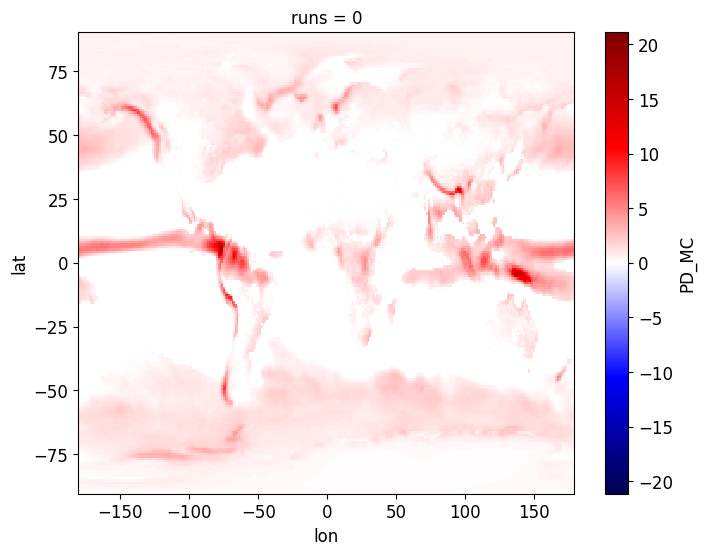

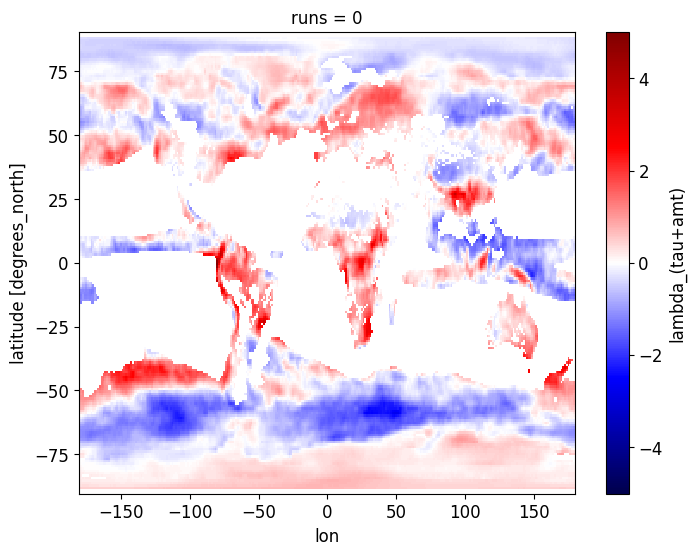

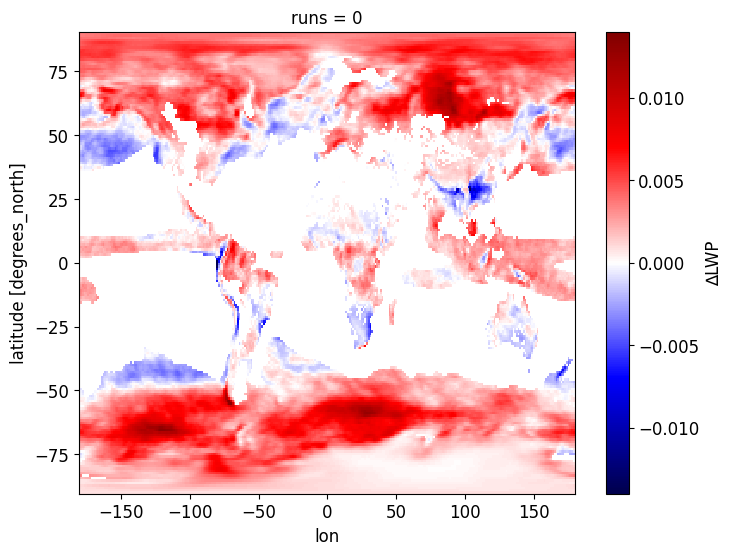

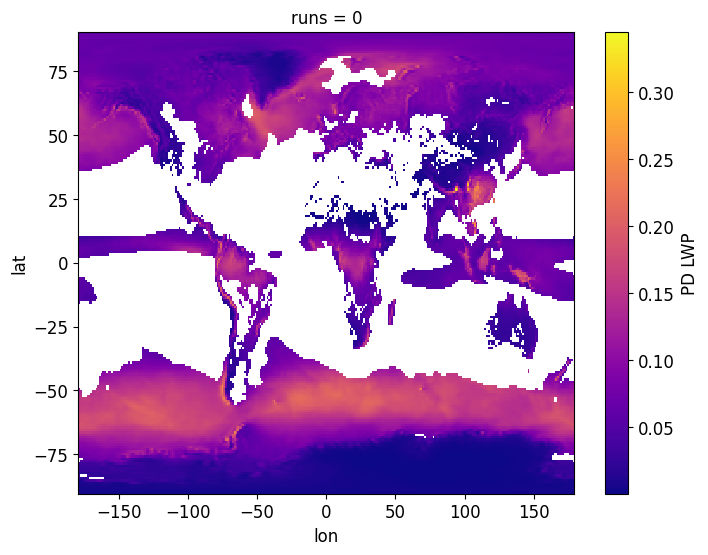

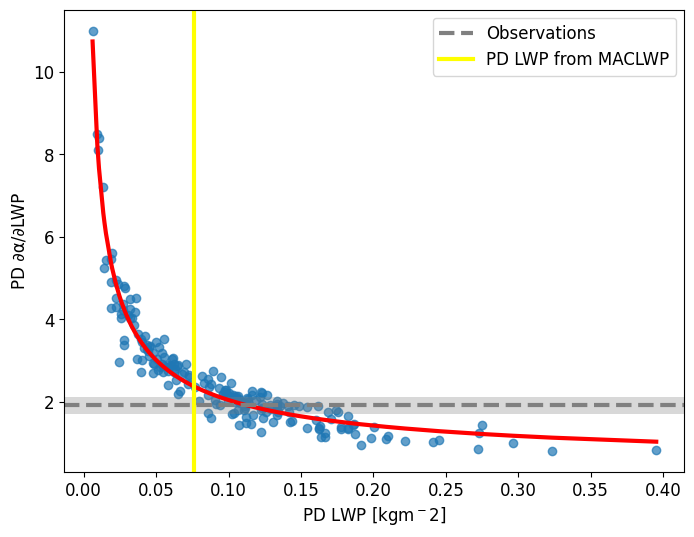

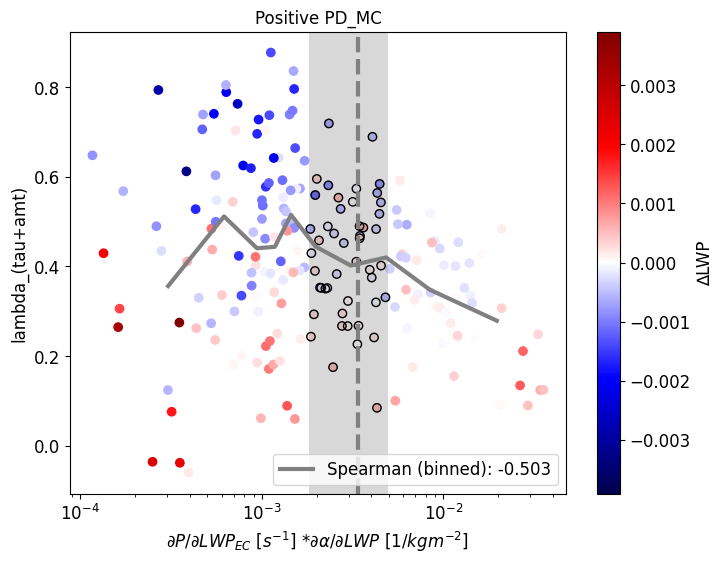

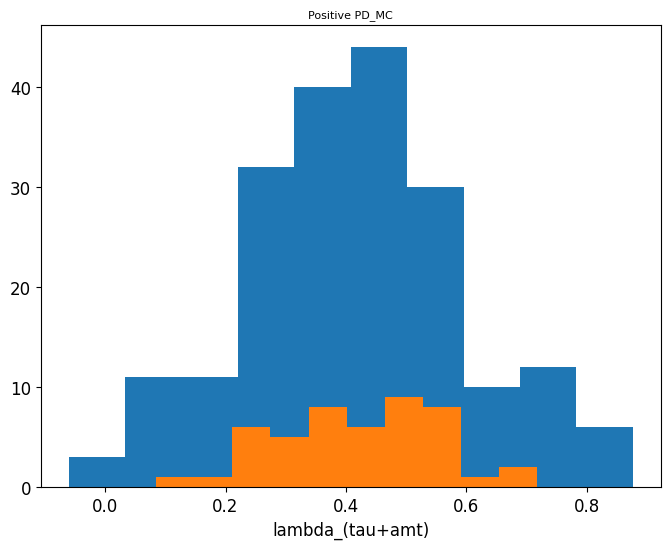

In [19]:
give_var, give_var_nm = [pe_maps_ol, 'PD_MC']
color_by, color_by_nm = [dLWP_g, '∆LWP']
# lambda
region_dic = {
    'global' : [0, 90]
}
# SWcld_tau_amt = trav_fbvar('SWcld_tot', region_dic)['global']
# SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
# SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
# LWcld_tau_amt = trav_fbvar('LWcld_tot', region_dic)['global']
# LWcld_tau_amt = LWcld_tau_amt.sel(runs=common_members)
# LWcld_tau_amt = LWcld_tau_amt.transpose('runs', 'lat', 'lon')
# totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt+LWcld_tau_amt, 'lambda_tot']

SWcld_tau_amt = trav_fbvar('SWcld_tau', region_dic)['global']  + trav_fbvar('SWcld_amt', region_dic)['global']
SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
LWcld_tau_amt = trav_fbvar('LWcld_amt', region_dic)['global'] + trav_fbvar('LWcld_tau', region_dic)['global']
LWcld_tau_amt = LWcld_tau_amt.sel(runs=common_members)
LWcld_tau_amt = LWcld_tau_amt.transpose('runs', 'lat', 'lon')
totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt+LWcld_tau_amt, 'lambda_(tau+amt)']

PPE_constrained, constrained_positive, cf_mean_positive, X_pe, Y_scatter, C_scatter, reg_mask = pos_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm,
    frac_pos_thresh=0.7,
    # lat_range = [-90, -30]
)

# --- Get the PD LWP in the masked region
PDLWP = load_xarray('LWPmap_ol')
PDLWP_xr = PDLWP.where(reg_mask)
PDLWP_xr.name = 'PD LWP'
plt.figure(); PDLWP_xr[0].plot(cmap='plasma')
PDLWP_xr_mean, _, _ = lat_weight_mean(PDLWP_xr)
dadlwp_MAC, dadlwp_PPE = dadlwp_func(PDLWP_xr_mean)

# --- Plot in the positive regime
X_scatter = X_pe * dadlwp_PPE
plt.figure()
scatter = plt.scatter(
    X_scatter, Y_scatter,
    c=C_scatter,
    cmap='seismic'
)

# plt.axvline(x=obs_pe_metric, color='grey', linestyle='--')
# plt.axvspan(lower_pe_metric, upper_pe_metric, color='grey', alpha=0.3)

# --- Binned correlation
y_bin, x_bin, _, count = my_binned(
    X_scatter.data, Y_scatter.data, num_bins=10, percentiles=True
)
c_ind = count > 10
corr, _ = stats.spearmanr(x_bin[c_ind], y_bin[c_ind])

plt.plot(
    x_bin[c_ind], y_bin[c_ind],
    'grey', label=f'Spearman (binned): {corr:.3f}'
)

# # --- Bootstrap correlation + regression
# bootstrap_results = bootstrap_corr_and_regression(
#     X_scatter,
#     Y_scatter,
#     n_boot=10000
# )

plt.xlabel(f'$∂P/∂LWP_{{EC}}$ $[s^{{-1}}]$ $* ∂α/∂LWP$ $[1/{{kgm^{{-2}}}}]$')
plt.ylabel(totcld_tau_amt_nm)
plt.title(f'Positive {give_var_nm}')
plt.legend()
cb = plt.colorbar(scatter)
cb.set_label(color_by_nm)
max_abs_value = max(abs(min(C_scatter).data), abs(max(C_scatter).data))
scatter.set_clim(-max_abs_value, max_abs_value)

# --- constrained scatter
# Error propogation
efficiency_product = obs_pe_metric * dadlwp_MAC  #dadlwp_obs
dadlwp_err = np.sqrt(0.1**2+0.03**2)  # Ci sent this. Check teams 5/8/24
sigma_efficiency_product = np.sqrt((ecpe_uncertainty)**2 + (dadlwp_err)**2) * efficiency_product
print("efficiency_product =", efficiency_product, "+/-", sigma_efficiency_product)
lower_bound_sigma_prod = efficiency_product - sigma_efficiency_product
upper_bound_sigma_prod = efficiency_product + sigma_efficiency_product
plt.axvline(x=efficiency_product, color='grey', linestyle='--', label='Observations')
plt.axvspan(lower_bound_sigma_prod, upper_bound_sigma_prod, facecolor='grey', alpha=0.3)
mask_cons = (
    (X_scatter >= lower_bound_sigma_prod) &
    (X_scatter <= upper_bound_sigma_prod)
)
X_scatter_constrained = X_scatter.where(mask_cons, drop=True)
constrained_positive = Y_scatter.where(mask_cons, drop=True)
plt.scatter(
    X_scatter_constrained,
    constrained_positive,
    facecolors='none',
    edgecolors='black'
)
plt.xscale('log')
# plt.savefig(
#     f'{fig_dir}lamcld_ecpe_{color_by_nm}_inPOS{give_var_nm}.png',
#     bbox_inches='tight',
#     facecolor='white',
#     dpi=600
# )

prior = Y_scatter.data
posterior = constrained_positive.data
plt.figure()
plt.hist(prior)
plt.hist(posterior)
plt.title(f'Positive {give_var_nm}', fontsize=title_fontsize)
plt.xlabel(totcld_tau_amt_nm)

(199, 86, 288)
R²: <xarray.DataArray ()>
array(0.94482853)
(80, 360)
efficiency_product = <xarray.DataArray 'meanfit' ()>
array(0.00339603) +/- <xarray.DataArray 'meanfit' ()>
array(0.00157943)


Text(0.5, 0, 'lambda_(tau+amt)')

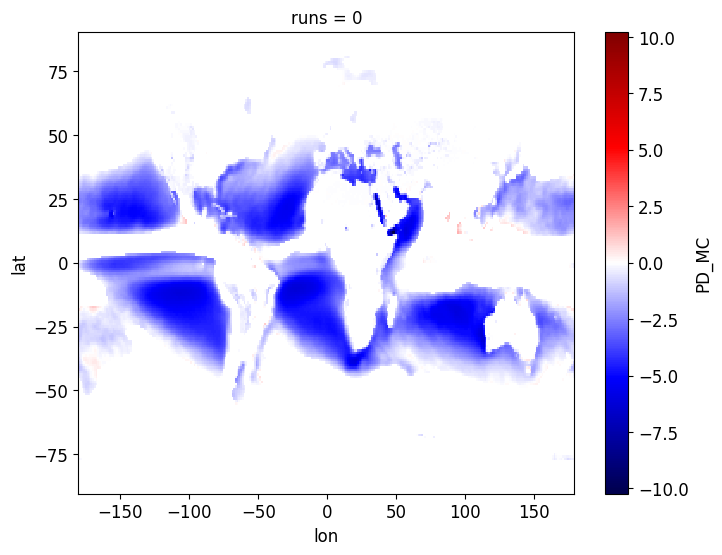

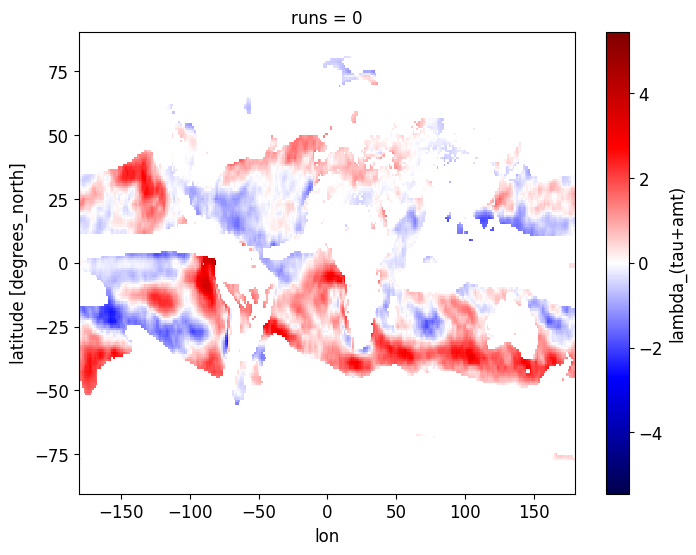

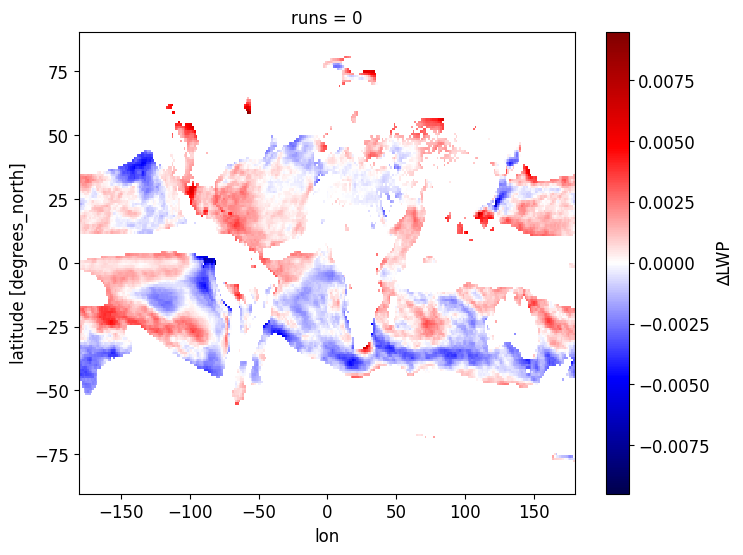

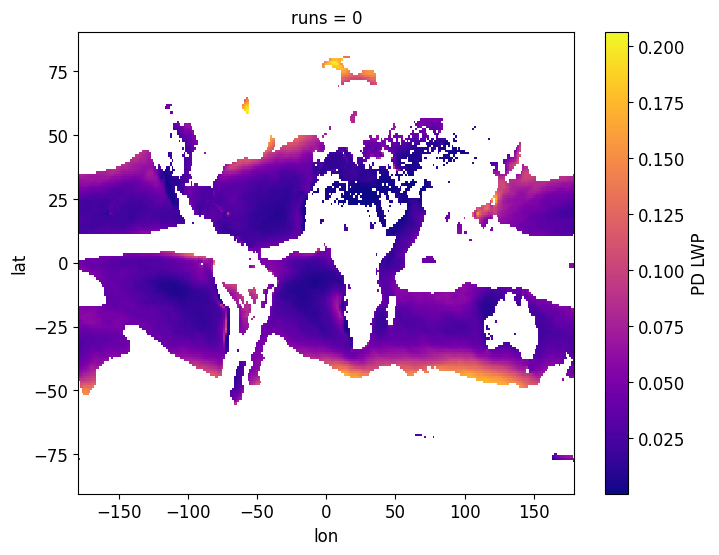

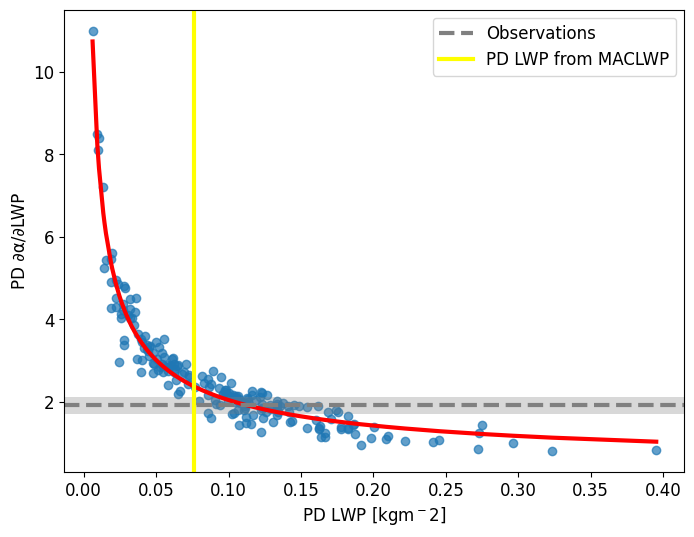

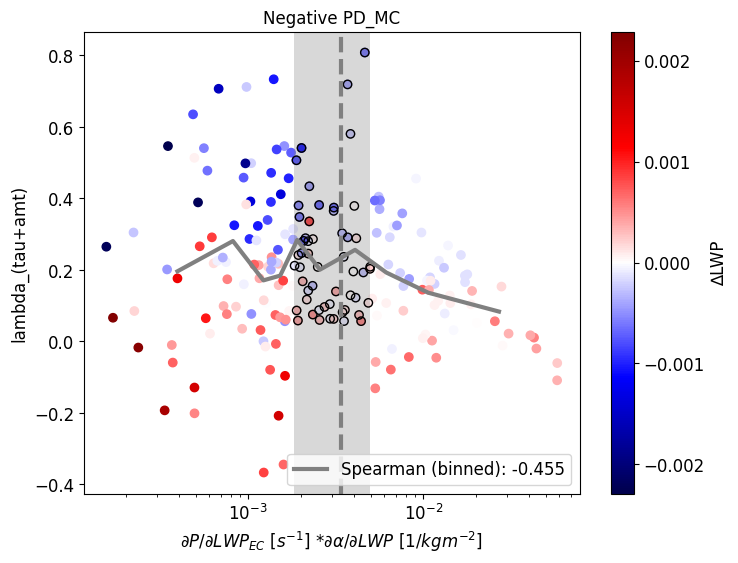

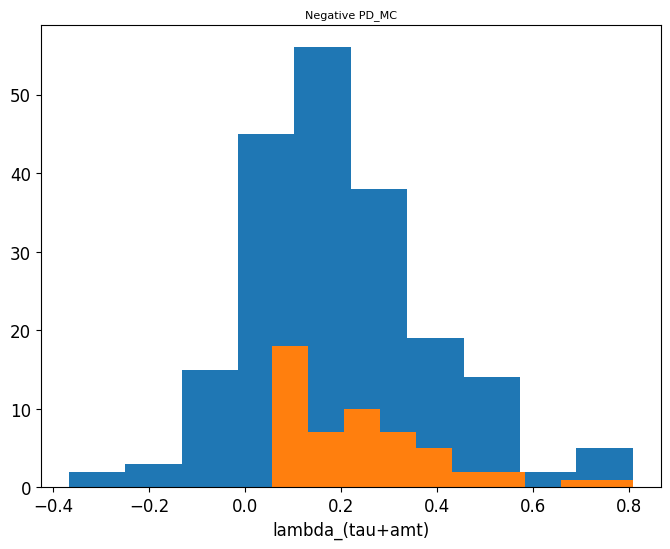

In [20]:
give_var, give_var_nm = [pe_maps_ol, 'PD_MC']
color_by, color_by_nm = [dLWP_g, '∆LWP']
# lambda
region_dic = {
    'global' : [0, 90]
}
# SWcld_tau_amt = trav_fbvar('SWcld_tot', region_dic)['global']
# SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
# SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
# LWcld_tau_amt = trav_fbvar('LWcld_tot', region_dic)['global']
# LWcld_tau_amt = LWcld_tau_amt.sel(runs=common_members)
# LWcld_tau_amt = LWcld_tau_amt.transpose('runs', 'lat', 'lon')
# totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt+LWcld_tau_amt, 'lambda_tot']

SWcld_tau_amt = trav_fbvar('SWcld_tau', region_dic)['global']  + trav_fbvar('SWcld_amt', region_dic)['global']
SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
LWcld_tau_amt = trav_fbvar('LWcld_amt', region_dic)['global'] + trav_fbvar('LWcld_tau', region_dic)['global']
LWcld_tau_amt = LWcld_tau_amt.sel(runs=common_members)
LWcld_tau_amt = LWcld_tau_amt.transpose('runs', 'lat', 'lon')
totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt+LWcld_tau_amt, 'lambda_(tau+amt)']

PPE_constrained, constrained_positive, cf_mean_positive, X_pe, Y_scatter, C_scatter, reg_mask = neg_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm,
    frac_pos_thresh=0.7,
    # lat_range = [-90, -30]
)

# --- Get the PD LWP in the masked region
PDLWP = load_xarray('LWPmap_ol')
PDLWP_xr = PDLWP.where(reg_mask)
PDLWP_xr.name = 'PD LWP'
plt.figure(); PDLWP_xr[0].plot(cmap='plasma')
PDLWP_xr_mean, _, _ = lat_weight_mean(PDLWP_xr)
dadlwp_MAC, dadlwp_PPE = dadlwp_func(PDLWP_xr_mean)

# --- Plot in the positive regime
X_scatter = X_pe * dadlwp_PPE
plt.figure()
scatter = plt.scatter(
    X_scatter, Y_scatter,
    c=C_scatter,
    cmap='seismic'
)

# plt.axvline(x=obs_pe_metric, color='grey', linestyle='--')
# plt.axvspan(lower_pe_metric, upper_pe_metric, color='grey', alpha=0.3)

# --- Binned correlation
y_bin, x_bin, _, count = my_binned(
    X_scatter.data, Y_scatter.data, num_bins=10, percentiles=True
)
c_ind = count > 10
corr, _ = stats.spearmanr(x_bin[c_ind], y_bin[c_ind])

plt.plot(
    x_bin[c_ind], y_bin[c_ind],
    'grey', label=f'Spearman (binned): {corr:.3f}'
)

plt.xlabel(f'$∂P/∂LWP_{{EC}}$ $[s^{{-1}}]$ $* ∂α/∂LWP$ $[1/{{kgm^{{-2}}}}]$')
plt.ylabel(totcld_tau_amt_nm)
plt.title(f'Negative {give_var_nm}')
plt.legend()
cb = plt.colorbar(scatter)
cb.set_label(color_by_nm)
max_abs_value = max(abs(min(C_scatter).data), abs(max(C_scatter).data))
scatter.set_clim(-max_abs_value, max_abs_value)

# --- constrained scatter
# Error propogation
efficiency_product = obs_pe_metric * dadlwp_MAC  #dadlwp_obs
dadlwp_err = np.sqrt(0.1**2+0.03**2)  # Ci sent this. Check teams 5/8/24
sigma_efficiency_product = np.sqrt((ecpe_uncertainty)**2 + (dadlwp_err)**2) * efficiency_product
print("efficiency_product =", efficiency_product, "+/-", sigma_efficiency_product)
lower_bound_sigma_prod = efficiency_product - sigma_efficiency_product
upper_bound_sigma_prod = efficiency_product + sigma_efficiency_product
plt.axvline(x=efficiency_product, color='grey', linestyle='--', label='Observations')
plt.axvspan(lower_bound_sigma_prod, upper_bound_sigma_prod, facecolor='grey', alpha=0.3)
mask_cons = (
    (X_scatter >= lower_bound_sigma_prod) &
    (X_scatter <= upper_bound_sigma_prod)
)
X_scatter_constrained = X_scatter.where(mask_cons, drop=True)
constrained_positive = Y_scatter.where(mask_cons, drop=True)
plt.scatter(
    X_scatter_constrained,
    constrained_positive,
    facecolors='none',
    edgecolors='black'
)
plt.xscale('log')
# plt.savefig(
#     f'{fig_dir}lamcld_ecpe_{color_by_nm}_inPOS{give_var_nm}.png',
#     bbox_inches='tight',
#     facecolor='white',
#     dpi=600
# )

prior = Y_scatter.data
posterior = constrained_positive.data
plt.figure()
plt.hist(prior)
plt.hist(posterior)
plt.title(f'Negative {give_var_nm}', fontsize=title_fontsize)
plt.xlabel(totcld_tau_amt_nm)

In [ ]:
give_var, give_var_nm = [pe_maps_ol, 'PD_MC']
color_by, color_by_nm = [dLWP_g, '∆LWP']
# lambda
region_dic = {
    'global' : [0, 90]
}
SWcld_tau_amt = trav_fbvar('SWcld_tau', region_dic)['global'] + trav_fbvar('SWcld_amt', region_dic)['global']
SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
LWcld_tau_amt = trav_fbvar('LWcld_tau', region_dic)['global'] + trav_fbvar('LWcld_amt', region_dic)['global']
LWcld_tau_amt = LWcld_tau_amt.sel(runs=common_members)
LWcld_tau_amt = LWcld_tau_amt.transpose('runs', 'lat', 'lon')
totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt+LWcld_tau_amt, 'lambda_tau_amt']

constrained_positive, cf_mean_positive, X_scatter, Y_scatter = pos_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm,
    # lat_range = [-90, -30]
)

constrained_negative, cf_mean_negative = neg_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm,
    # lat_range = [-90, -30]
)

In [ ]:
give_var, give_var_nm = [pe_maps_ol, 'PD_MC']
color_by, color_by_nm = [dLWP_g, '∆LWP']
# lambda
region_dic = {
    'global' : [0, 90]
}
SWcld_tau_amt = trav_fbvar('SWcld_tau', region_dic)['global'] + trav_fbvar('SWcld_amt', region_dic)['global']
SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt, 'lambda_SW_tau_amt']

constrained_positive, cf_mean_positive, _, _ = pos_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm
)

constrained_negative, cf_mean_negative = neg_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm
)

# ∆MC

(199, 86, 288)
R²: <xarray.DataArray ()>
array(0.94482853)
(80, 360)
efficiency_product = <xarray.DataArray 'meanfit' ()>
array(0.00339603) +/- <xarray.DataArray 'meanfit' ()>
array(0.00157943)


Text(0.5, 0, 'lambda_tot')

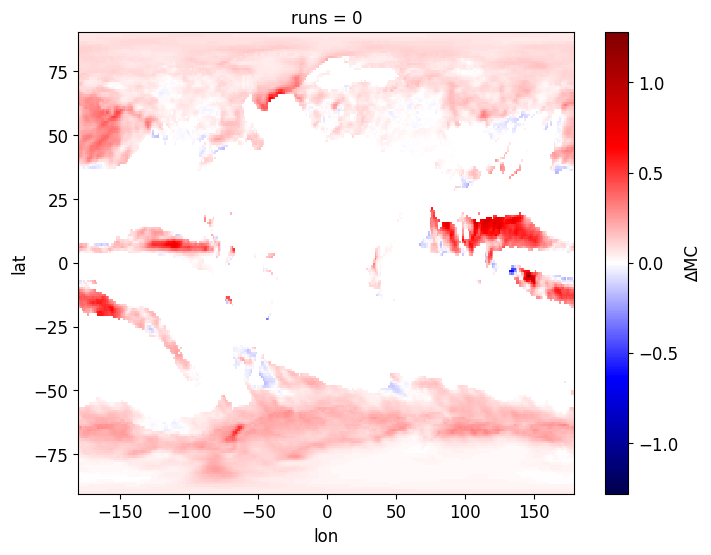

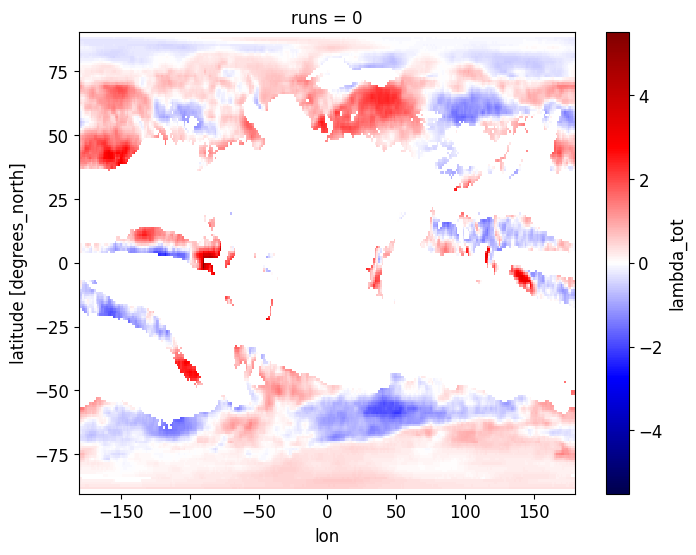

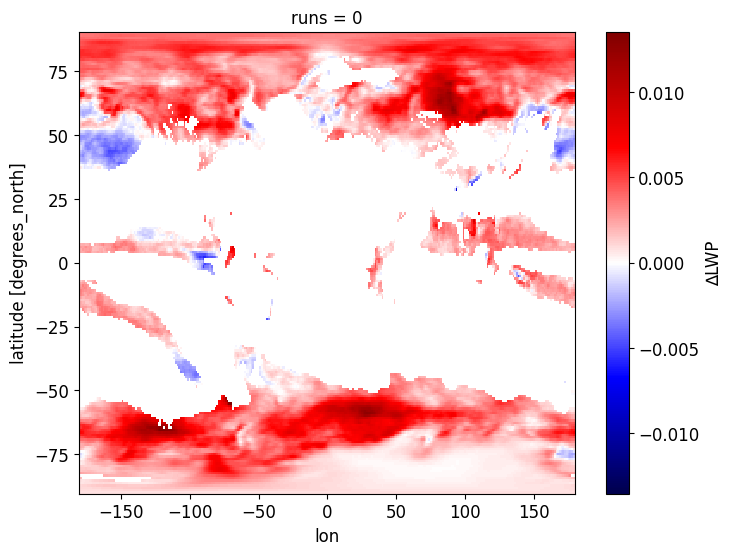

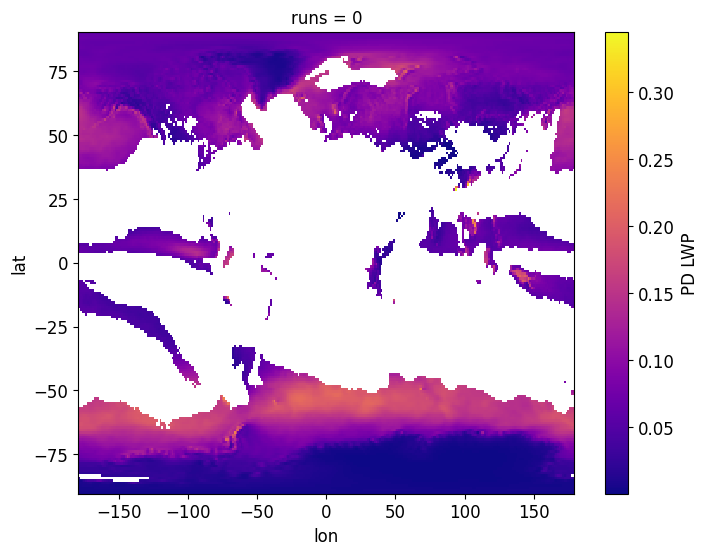

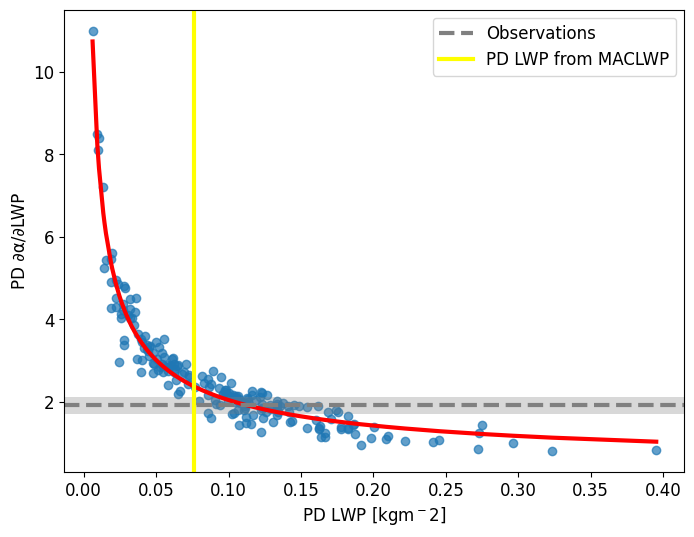

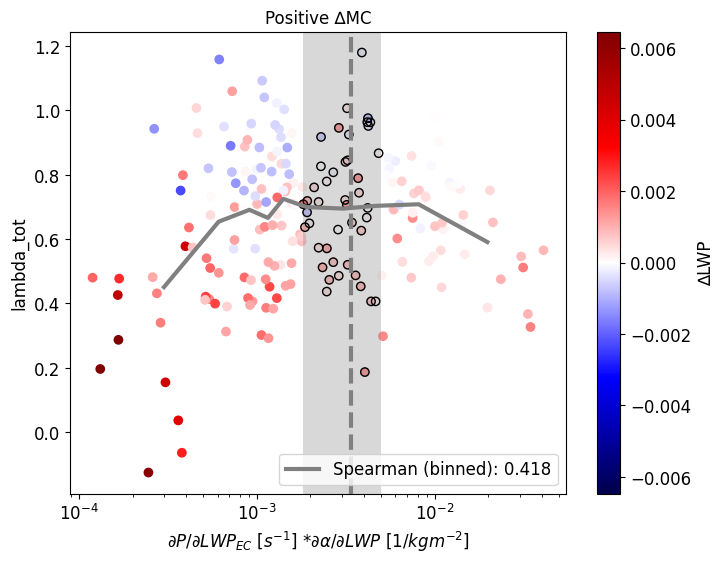

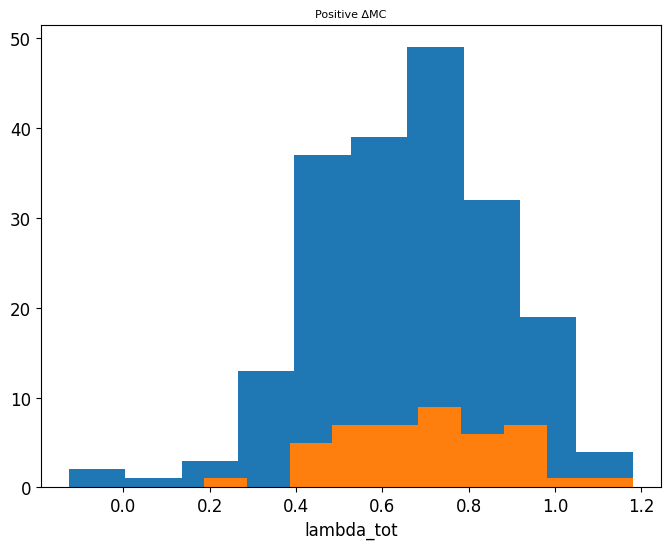

In [21]:
give_var, give_var_nm = [dPE, '∆MC']
color_by, color_by_nm = [dLWP_g, '∆LWP']
# lambda
region_dic = {
    'global' : [0, 90]
}
# SWcld_tau_amt = trav_fbvar('SWcld_tau', region_dic)['global']  + trav_fbvar('SWcld_amt', region_dic)['global']
# SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
# SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
# LWcld_tau_amt = trav_fbvar('LWcld_amt', region_dic)['global'] + trav_fbvar('LWcld_tau', region_dic)['global']
# LWcld_tau_amt = LWcld_tau_amt.sel(runs=common_members)
# LWcld_tau_amt = LWcld_tau_amt.transpose('runs', 'lat', 'lon')
# totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt+LWcld_tau_amt, 'lambda_(tau+amt)']

SWcld_tau_amt = trav_fbvar('SWcld_tot', region_dic)['global']
SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
LWcld_tau_amt = trav_fbvar('LWcld_tot', region_dic)['global']
LWcld_tau_amt = LWcld_tau_amt.sel(runs=common_members)
LWcld_tau_amt = LWcld_tau_amt.transpose('runs', 'lat', 'lon')
totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt+LWcld_tau_amt, 'lambda_tot']

PPE_constrained, constrained_positive, cf_mean_positive, X_pe, Y_scatter, C_scatter, reg_mask = pos_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm,
    frac_pos_thresh=0.7,
    # lat_range = [-90, -30]
)

# --- Get the PD LWP in the masked region
PDLWP = load_xarray('LWPmap_ol')
PDLWP_xr = PDLWP.where(reg_mask)
PDLWP_xr.name = 'PD LWP'
plt.figure(); PDLWP_xr[0].plot(cmap='plasma')
PDLWP_xr_mean, _, _ = lat_weight_mean(PDLWP_xr)
dadlwp_MAC, dadlwp_PPE = dadlwp_func(PDLWP_xr_mean)

# --- Plot in the positive regime
X_scatter = X_pe * dadlwp_PPE
plt.figure()
scatter = plt.scatter(
    X_scatter, Y_scatter,
    c=C_scatter,
    cmap='seismic'
)

# plt.axvline(x=obs_pe_metric, color='grey', linestyle='--')
# plt.axvspan(lower_pe_metric, upper_pe_metric, color='grey', alpha=0.3)

# --- Binned correlation
y_bin, x_bin, _, count = my_binned(
    X_scatter.data, Y_scatter.data, num_bins=10, percentiles=True
)
c_ind = count > 10
corr, _ = stats.spearmanr(x_bin[c_ind], y_bin[c_ind])

plt.plot(
    x_bin[c_ind], y_bin[c_ind],
    'grey', label=f'Spearman (binned): {corr:.3f}'
)

# # --- Bootstrap correlation + regression
# bootstrap_results = bootstrap_corr_and_regression(
#     X_scatter,
#     Y_scatter,
#     n_boot=10000
# )

plt.xlabel(f'$∂P/∂LWP_{{EC}}$ $[s^{{-1}}]$ $* ∂α/∂LWP$ $[1/{{kgm^{{-2}}}}]$')
plt.ylabel(totcld_tau_amt_nm)
plt.title(f'Positive {give_var_nm}')
plt.legend()
cb = plt.colorbar(scatter)
cb.set_label(color_by_nm)
max_abs_value = max(abs(min(C_scatter).data), abs(max(C_scatter).data))
scatter.set_clim(-max_abs_value, max_abs_value)

# --- constrained scatter
# Error propogation
efficiency_product = obs_pe_metric * dadlwp_MAC  #dadlwp_obs
dadlwp_err = np.sqrt(0.1**2+0.03**2)  # Ci sent this. Check teams 5/8/24
sigma_efficiency_product = np.sqrt((ecpe_uncertainty)**2 + (dadlwp_err)**2) * efficiency_product
print("efficiency_product =", efficiency_product, "+/-", sigma_efficiency_product)
lower_bound_sigma_prod = efficiency_product - sigma_efficiency_product
upper_bound_sigma_prod = efficiency_product + sigma_efficiency_product
plt.axvline(x=efficiency_product, color='grey', linestyle='--', label='Observations')
plt.axvspan(lower_bound_sigma_prod, upper_bound_sigma_prod, facecolor='grey', alpha=0.3)
mask_cons = (
    (X_scatter >= lower_bound_sigma_prod) &
    (X_scatter <= upper_bound_sigma_prod)
)
X_scatter_constrained = X_scatter.where(mask_cons, drop=True)
constrained_positive = Y_scatter.where(mask_cons, drop=True)
plt.scatter(
    X_scatter_constrained,
    constrained_positive,
    facecolors='none',
    edgecolors='black'
)
plt.xscale('log')
# plt.savefig(
#     f'{fig_dir}lamcld_ecpe_{color_by_nm}_inPOS{give_var_nm}.png',
#     bbox_inches='tight',
#     facecolor='white',
#     dpi=600
# )

prior = Y_scatter.data
posterior = constrained_positive.data
plt.figure()
plt.hist(prior)
plt.hist(posterior)
plt.title(f'Positive {give_var_nm}', fontsize=title_fontsize)
plt.xlabel(totcld_tau_amt_nm)

(199, 86, 288)
R²: <xarray.DataArray ()>
array(0.94482853)
(80, 360)
efficiency_product = <xarray.DataArray 'meanfit' ()>
array(0.00339603) +/- <xarray.DataArray 'meanfit' ()>
array(0.00157943)


Text(0.5, 0, 'lambda_tot')

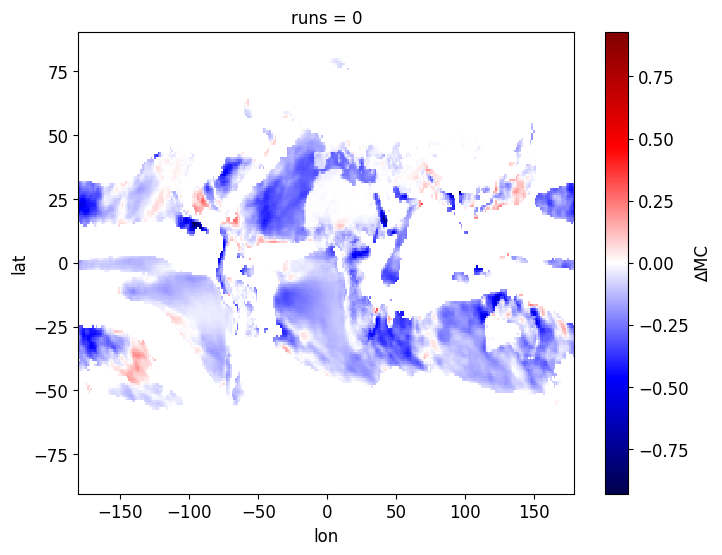

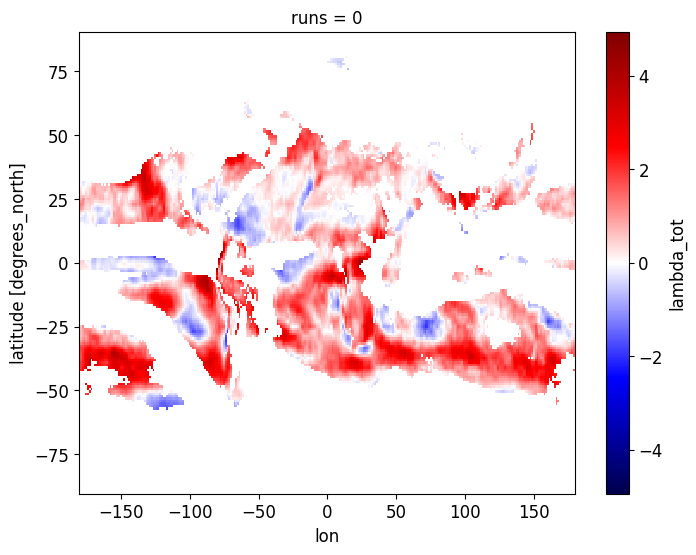

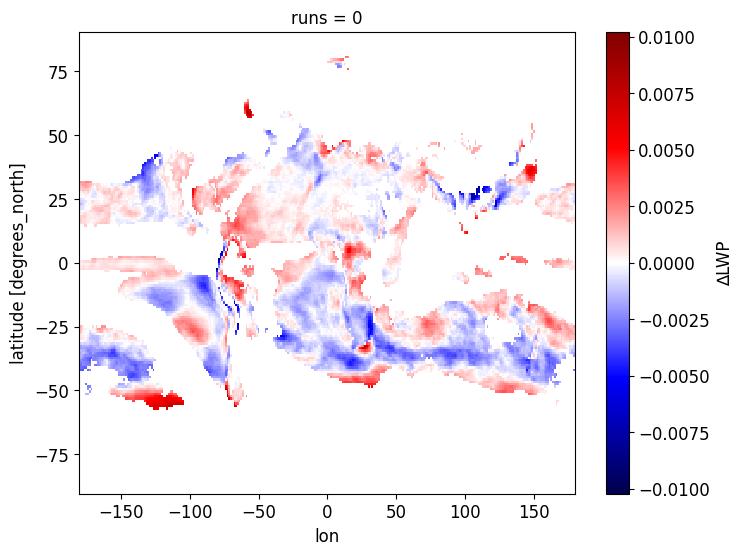

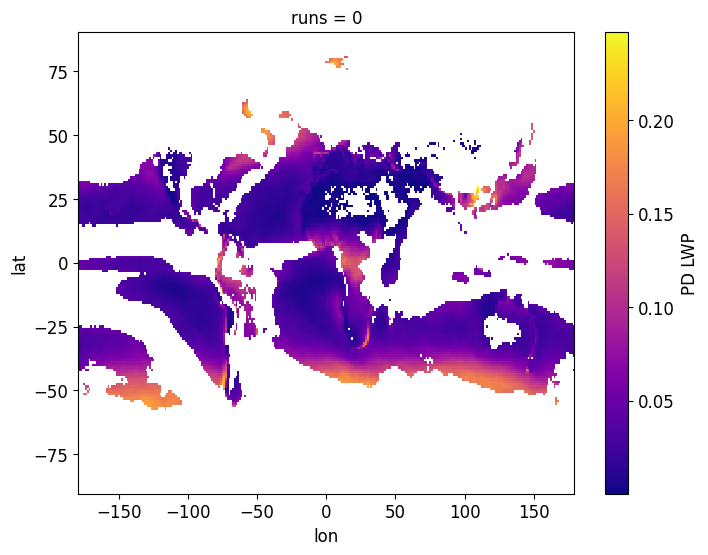

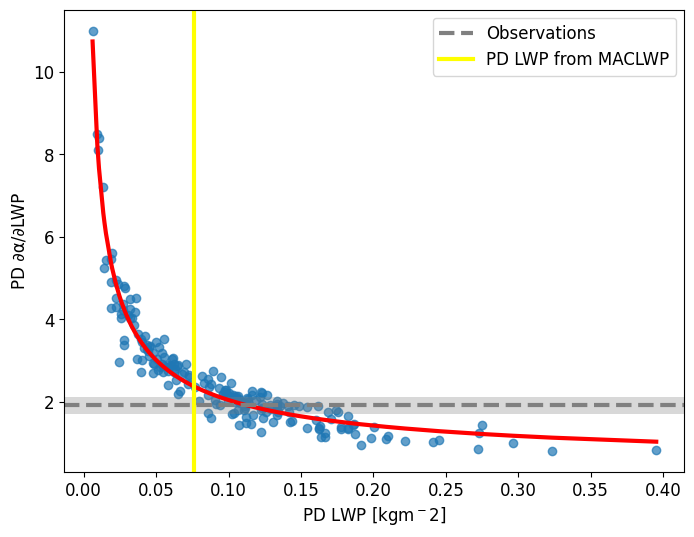

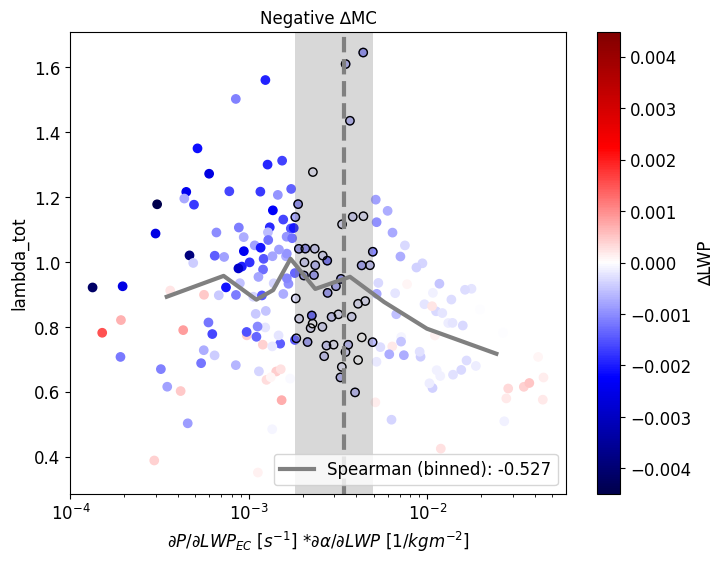

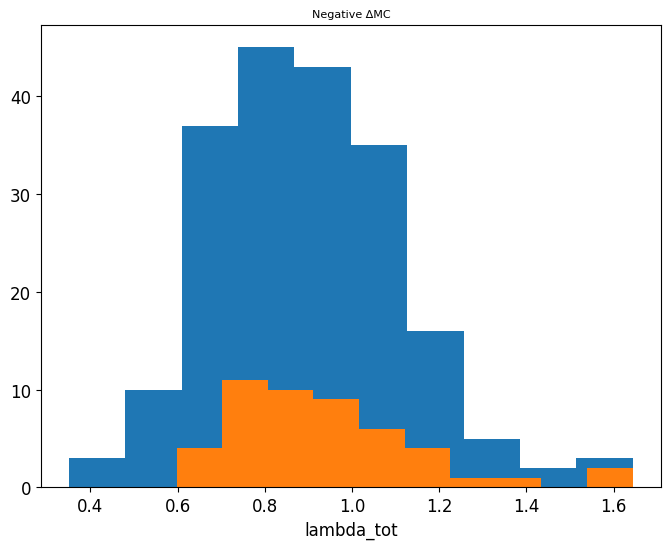

In [22]:
give_var, give_var_nm = [dPE, '∆MC']
color_by, color_by_nm = [dLWP_g, '∆LWP']
# lambda
region_dic = {
    'global' : [0, 90]
}
# SWcld_tau_amt = trav_fbvar('SWcld_tau', region_dic)['global']  + trav_fbvar('SWcld_amt', region_dic)['global']
# SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
# SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
# LWcld_tau_amt = trav_fbvar('LWcld_amt', region_dic)['global'] + trav_fbvar('LWcld_tau', region_dic)['global']
# LWcld_tau_amt = LWcld_tau_amt.sel(runs=common_members)
# LWcld_tau_amt = LWcld_tau_amt.transpose('runs', 'lat', 'lon')
# totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt+LWcld_tau_amt, 'lambda_(tau+amt)']

SWcld_tau_amt = trav_fbvar('SWcld_tot', region_dic)['global']
SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
LWcld_tau_amt = trav_fbvar('LWcld_tot', region_dic)['global']
LWcld_tau_amt = LWcld_tau_amt.sel(runs=common_members)
LWcld_tau_amt = LWcld_tau_amt.transpose('runs', 'lat', 'lon')
totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt+LWcld_tau_amt, 'lambda_tot']

PPE_constrained, constrained_positive, cf_mean_positive, X_pe, Y_scatter, C_scatter, reg_mask = neg_correlation(
    give_var, give_var_nm, 
    color_by, color_by_nm, 
    totcld_tau_amt, totcld_tau_amt_nm,
    frac_pos_thresh=0.7,
    # lat_range = [23, 90]
)

# --- Get the PD LWP in the masked region
PDLWP = load_xarray('LWPmap_ol')
PDLWP_xr = PDLWP.where(reg_mask)
PDLWP_xr.name = 'PD LWP'
plt.figure(); PDLWP_xr[0].plot(cmap='plasma')
PDLWP_xr_mean, _, _ = lat_weight_mean(PDLWP_xr)
dadlwp_MAC, dadlwp_PPE = dadlwp_func(PDLWP_xr_mean)

# --- Plot in the positive regime
X_scatter = X_pe * dadlwp_PPE
plt.figure()
scatter = plt.scatter(
    X_scatter, Y_scatter,
    c=C_scatter,
    cmap='seismic'
)

# plt.axvline(x=obs_pe_metric, color='grey', linestyle='--')
# plt.axvspan(lower_pe_metric, upper_pe_metric, color='grey', alpha=0.3)

# --- Binned correlation
y_bin, x_bin, _, count = my_binned(
    X_scatter.data, Y_scatter.data, num_bins=10, percentiles=True
)
c_ind = count > 10
corr, _ = stats.spearmanr(x_bin[c_ind], y_bin[c_ind])

plt.plot(
    x_bin[c_ind], y_bin[c_ind],
    'grey', label=f'Spearman (binned): {corr:.3f}'
)

# # --- Bootstrap correlation + regression
# bootstrap_results = bootstrap_corr_and_regression(
#     X_scatter,
#     Y_scatter,
#     n_boot=10000
# )

plt.xlabel(f'$∂P/∂LWP_{{EC}}$ $[s^{{-1}}]$ $* ∂α/∂LWP$ $[1/{{kgm^{{-2}}}}]$')
plt.ylabel(totcld_tau_amt_nm)
plt.title(f'Negative {give_var_nm}')
plt.legend()
cb = plt.colorbar(scatter)
cb.set_label(color_by_nm)
max_abs_value = max(abs(min(C_scatter).data), abs(max(C_scatter).data))
scatter.set_clim(-max_abs_value, max_abs_value)

# --- constrained scatter
# Error propogation
efficiency_product = obs_pe_metric * dadlwp_MAC  #dadlwp_obs
dadlwp_err = np.sqrt(0.1**2+0.03**2)  # Ci sent this. Check teams 5/8/24
sigma_efficiency_product = np.sqrt((ecpe_uncertainty)**2 + (dadlwp_err)**2) * efficiency_product
print("efficiency_product =", efficiency_product, "+/-", sigma_efficiency_product)
lower_bound_sigma_prod = efficiency_product - sigma_efficiency_product
upper_bound_sigma_prod = efficiency_product + sigma_efficiency_product
plt.axvline(x=efficiency_product, color='grey', linestyle='--', label='Observations')
plt.axvspan(lower_bound_sigma_prod, upper_bound_sigma_prod, facecolor='grey', alpha=0.3)
mask_cons = (
    (X_scatter >= lower_bound_sigma_prod) &
    (X_scatter <= upper_bound_sigma_prod)
)
X_scatter_constrained = X_scatter.where(mask_cons, drop=True)
constrained_positive = Y_scatter.where(mask_cons, drop=True)
plt.scatter(
    X_scatter_constrained,
    constrained_positive,
    facecolors='none',
    edgecolors='black'
)
plt.xscale('log')
# plt.savefig(
#     f'{fig_dir}lamcld_ecpe_{color_by_nm}_inPOS{give_var_nm}.png',
#     bbox_inches='tight',
#     facecolor='white',
#     dpi=600
# )

prior = Y_scatter.data
posterior = constrained_positive.data
plt.figure()
plt.hist(prior)
plt.hist(posterior)
plt.title(f'Negative {give_var_nm}', fontsize=title_fontsize)
plt.xlabel(totcld_tau_amt_nm)

In [ ]:
# give_var, give_var_nm = [dPE, '∆MC']
# color_by, color_by_nm = [dLWP_g, '∆LWP']
# # lambda
# region_dic = {
#     'global' : [0, 90]
# }
# SWcld_tau_amt = trav_fbvar('SWcld_tot', region_dic)['global']
# SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
# SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
# LWcld_tau_amt = trav_fbvar('LWcld_tot', region_dic)['global']
# LWcld_tau_amt = LWcld_tau_amt.sel(runs=common_members)
# LWcld_tau_amt = LWcld_tau_amt.transpose('runs', 'lat', 'lon')
# totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt+LWcld_tau_amt, 'lambda_tot']

# constrained_positive, cf_mean_positive, X_scatter, Y_scatter = pos_correlation(
#     give_var, give_var_nm, 
#     color_by, color_by_nm, 
#     totcld_tau_amt, totcld_tau_amt_nm,
#     lat_range = [-90, -30]
# )

# constrained_negative, cf_mean_negative = neg_correlation(
#     give_var, give_var_nm, 
#     color_by, color_by_nm, 
#     totcld_tau_amt, totcld_tau_amt_nm,
#     lat_range = [-90, -30]
# )

In [ ]:
# give_var, give_var_nm = [dPE, '∆MC']
# color_by, color_by_nm = [dLWP_g, '∆LWP']
# # lambda
# region_dic = {
#     'global' : [0, 90]
# }
# SWcld_tau_amt = trav_fbvar('SWcld_tau', region_dic)['global'] + trav_fbvar('SWcld_amt', region_dic)['global']
# SWcld_tau_amt = SWcld_tau_amt.sel(runs=common_members)
# SWcld_tau_amt = SWcld_tau_amt.transpose('runs', 'lat', 'lon')
# LWcld_tau_amt = trav_fbvar('LWcld_tau', region_dic)['global'] + trav_fbvar('LWcld_amt', region_dic)['global']
# LWcld_tau_amt = LWcld_tau_amt.sel(runs=common_members)
# LWcld_tau_amt = LWcld_tau_amt.transpose('runs', 'lat', 'lon')
# totcld_tau_amt, totcld_tau_amt_nm = [SWcld_tau_amt+LWcld_tau_amt, 'lambda_tau_amt']

# constrained_positive, cf_mean_positive, X_scatter, Y_scatter = pos_correlation(
#     give_var, give_var_nm, 
#     color_by, color_by_nm, 
#     totcld_tau_amt, totcld_tau_amt_nm,
#     lat_range = [30, 90]
# )

# constrained_negative, cf_mean_negative = neg_correlation(
#     give_var, give_var_nm, 
#     color_by, color_by_nm, 
#     totcld_tau_amt, totcld_tau_amt_nm,
#     lat_range = [30, 90]
# )

In [ ]:
# --- Florent's emergent constraint ---
# # for ii in range(NR):
# #   print(ii)
#   # xx = xall[ii,:]
#   # y1 = yall[ii,:]
#   # model_pdf = model_pdf_all[ii,:,:]
# import tools as tl
# import scipy as sp

# # Correlation coefficient
# xx, y1 = X_scatter, Y_scatter
# corr=np.corrcoef(xx,y1)[0,1]

# #### Confidence interval slope
# p, cov  = np.polyfit(xx, y1, 1, cov=True) 
# #print 'p ',p
# y_model = tl.equation(p, xx)
# # Statistics
# n       = y1.size                                           # number of observations
# m       = p.size                                            # number of parameters
# dof     = n - m                                             # degrees of freedom
# t       = stats.t.ppf(0.95, n - m)                          # used for CI and PI bands
#  # Estimates of Error in Data/Model
# resid    = y1 - y_model                           
# chi2     = np.sum((resid/y_model)**2)                       # chi-squared; estimates error in data
# chi2_red = chi2/(dof)                                       # reduced chi-squared; measures goodness of fit
# s_err    = np.sqrt(np.sum(resid**2)/(dof))                  # standard deviation of the error

# # Inference with confidence interval of the curve
# nbboot  = 10000                         # number of bootstrap
# sigma   = s_err                         # Standard deviation of the error
# yinfer  = np.zeros(nbboot)
# bootindex = np.random.randint
# NB = len(xx)  # geethma added this
# obsmean = obs_grad_LWP_PRC  # geethma added this
# for ij in range(nbboot):
#     idx = bootindex(0, NB-1, NB)
#     #resamp_resid = resid[bootindex(0, len(resid)-1, len(resid))]
#     # Make coeffs of for polys
#     pc = sp.polyfit(xx[idx], y1[idx], 1) # error in xx?
#     yinfer[ij]  = pc[0]*obsmean + pc[1] + sigma*np.random.randn()  # prediction inference

# # Confidence interval of yinfer
# yimean  = np.mean(yinfer)
# yistd   = np.std(yinfer)
# yi66    = [yimean-yistd,yimean+yistd]
# yi90    = [yimean-2.0*yistd,yimean+2.0*yistd]

# # Kullback–Leibler divergence
# log_llh   = np.zeros(NB)
# for ij in range(NB):
#     #plt.plot(xplot, obspdf, 'g', xplot, model_pdf[ij,:], 'r');plt.show()
#     log_llh[ij] = np.trapz(xplot, obspdf * np.log(obspdf / model_pdf[ij,:]))
#     #print log_llh[ij],xx[ij],y1[ij],sigma_mod[ij]

# # model weights
# w              = np.exp(log_llh - np.nanmax(log_llh));
# w_model        = w/np.nansum(w);

# yee       = np.linspace(min(y1), max(y1), NB)
# idx       = np.argsort(y1)
# kernel    = stats.gaussian_kde(y1[idx])
# ECSprior  = kernel(yee)
# kernel_w  = stats.gaussian_kde(y1[idx],weights=w_model[idx])
# ECSpost   = kernel_w(yee)

# priormax           = yee[ECSprior==max(ECSprior)]
# priorl90,prioru90  = tl.confidence_intervals(ECSprior,yee,.9)
# priorl66,prioru66  = tl.confidence_intervals(ECSprior,yee,.66)
# postmax            = yee[ECSpost==max(ECSpost)]
# postl90,postu90    = tl.confidence_intervals(ECSpost,yee,.9)
# postl66,postu66    = tl.confidence_intervals(ECSpost,yee,.66)
